# First Pipeline - Audio Classification with CNNs

### Part 1 - Where did the data come from?

The human mouth is capable of making a whole range of voices that one might not have thought of before. I was inspired by Tom Thum and his video on beatboxing (https://www.youtube.com/watch?v=GNZBSZD16cY&ab_channel=TEDxTalks) around 7 years ago, and began my journey of converting my mouth into an orchestra. This project focuses on audio files, specifically in the .wav format, that belong to either class of sounding like a kick drum, a high hat, a synth, a trumpet, or a snare. The whole dataset comprises of 234 datapoints with some class imbalance; these files were obtained in the following manner: 30 for each class from Seth Adam's GitHub (originally obtained from Kaggle: https://www.kaggle.com/c/freesound-audio-tagging), 49 recorded by myself (9 high hats and 10 each for the other classes), and the remaining 35 from Echo Sound Works "Aura One Shots" free sample pack (https://www.echosoundworks.com/aura-one-shots).

### And why is it just this data?

Rather than expanding the number of classes to include more precise classifications used in beatbox such as throat bass, liprolls, inward snares, outward snares, or the myriad number of variations on kick drums and synths, this project intends to create a tool for the beginner beatboxer and as such is focusing on the 5 most distinct and useful sounds to learn. 

### Part 2 - Conversion of Data

#### Importing all necessary modules for remainder of code

In [704]:
import os
import tkinter as tk
import csv
import pyaudio
import wave
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pandas as pd
import librosa
from python_speech_features import mfcc, logfbank
from tqdm import tqdm
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
import pickle
from keras.callbacks import ModelCheckpoint
import visualkeras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#### DataFrame: adding recorded and external .wav files into a csv 

In [705]:
#Put own sounds into csvs

#Boolean to prevent repetition once created,
#set to False if csv not generated

files_created = True 

#Changing Siren to Synth for the final conversion
own_sounds = ['Hats','Kicks','Siren','Snare','Trumpet']

if not files_created:
    print('Creating CSV files')
    
    #going through the 5 named folders
    for folder_name in own_sounds:
        directory = 'test/{}'.format(folder_name)  
        output_file = '{}.csv'.format(folder_name)

        #write file name as row in individual csv
        with open(output_file, 'w', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(['File'])  #header
            for filename in os.listdir(directory):
                csvwriter.writerow([filename])
    print('Files created.')
    
else:
    print('CSV Files have already been created.')

CSV Files have already been created.


In [706]:
#Put downloaded files into csvs

files_created = True 
external_sounds = ['Hat','Kick','Snare','Synth','Trumpet']

if not files_created:
    print('Creating CSV files')
    for folder_name in external_sounds:
        directory = 'Training/DownloadedFiles/{}'.format(folder_name)  
        output_file = '{}1.csv'.format(folder_name)
        with open(output_file, 'w', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(['File'])
            for filename in os.listdir(directory):
                csvwriter.writerow([filename])
                
    print('Files created.')

else:
    print('CSV Files have already been created.')

CSV Files have already been created.


The above code cells created 10 individual csv files for the recorded and external data. They are then moved into the folder "Save" manually. The following code cell then merges them into one. 

In [707]:
#Merge all csvs into one

files_created = True 

#Path to access 10 csv files
path = 'Save'
all_files = os.listdir(path)

df_list = []
if not files_created:
    print('Creating merged CSV file')
    for file in all_files:
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(path, file))
            df_list.append(df)

    #Concatenate all the individual dataframes in df_list into one and save
    merged_df = pd.concat(df_list, ignore_index=True)

    merged_df.to_csv('merged.csv', index=False) 
    print('Merged CSV created')
    
else:
    print('Merged CSV has already been created')

Merged CSV has already been created


The dataframe now looks like this, for the purposes of this assignment, the main csv file is named "merged_and_processed.csv":

In [708]:
df = pd.read_csv('merged_and_processed.csv')
display(df.head())

,File,Instrument
0,06c48eab.wav,HighHat
1,078f7ac0.wav,HighHat
2,09a1cfd7.wav,HighHat
3,0ed06544.wav,HighHat
4,2032be87.wav,HighHat


### Part 3 - The Hard Part, Pre-processing

#### Manual entry
Note: The quickest way to get the second column of the data frame to have the correct instrument labels was to create the individual csv files, enter them manually and add the relevant column. There is probably a Pythonic way to do this but with a dataset of this size, this was a manageable technique.

#### Class Balance
The first thing to observe now that we have our data in a neat pandas dataframe is the class distribution i.e. how many of each instrument class do we have in the data frame? The following code-cell plots a pie-chart demonstrating the class balance for the dataset. We can observe that the Trumpet class consists about 31% of the files (the most), and Kick Drums at around 15% (the least). Though there is some class imbalance, it is not so severe as to worry about: an equal balance would be 20% each but it is also important to remember that a perfect class balance is likely not representative of real-world samples that the model would receive.

C:\Users\raphael khalid\AppData\Local\Temp\ipykernel_5960\4196780358.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, signal = wavfile.read('wavfiles/'+file)


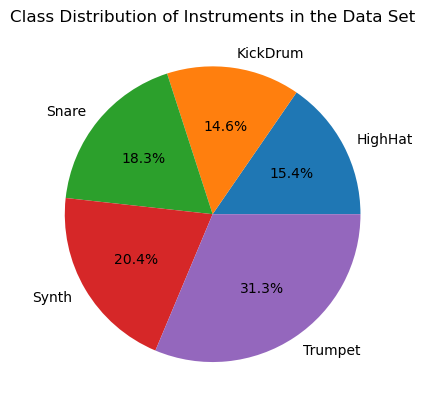

In [709]:
#Class Distribution Plot

df = pd.read_csv('merged.csv')

df.set_index('File',inplace=True)


#Create a column with length of wav file in seconds
for file in df.index:
    rate, signal = wavfile.read('wavfiles/'+file)
    df.at[file,'Length(s)'] = signal.shape[0]/rate   #this line gets time in s
    
classes = list(np.unique(df.Instrument))

distribution = df.groupby(['Instrument'])['Length(s)'].mean()

plt.pie(distribution,labels=classes,autopct='%1.1f%%',shadow=False)
plt.title('Class Distribution of Instruments in the Data Set')
plt.plot()
plt.show()
df.reset_index(inplace=True)

#Error box is likely due to some .wav file metadata which scipy cannot parse but is
#to the data pre-processing

#### Signals

What does our data actually look like right now? The code cell below gets a sample .wav file and collects relevant data. We first start with the signal which is plotted below. There is some distinction between the various plots but there is a great deal of wasted space e.g. when the sample dies down, or the silence at the start of the sample. 

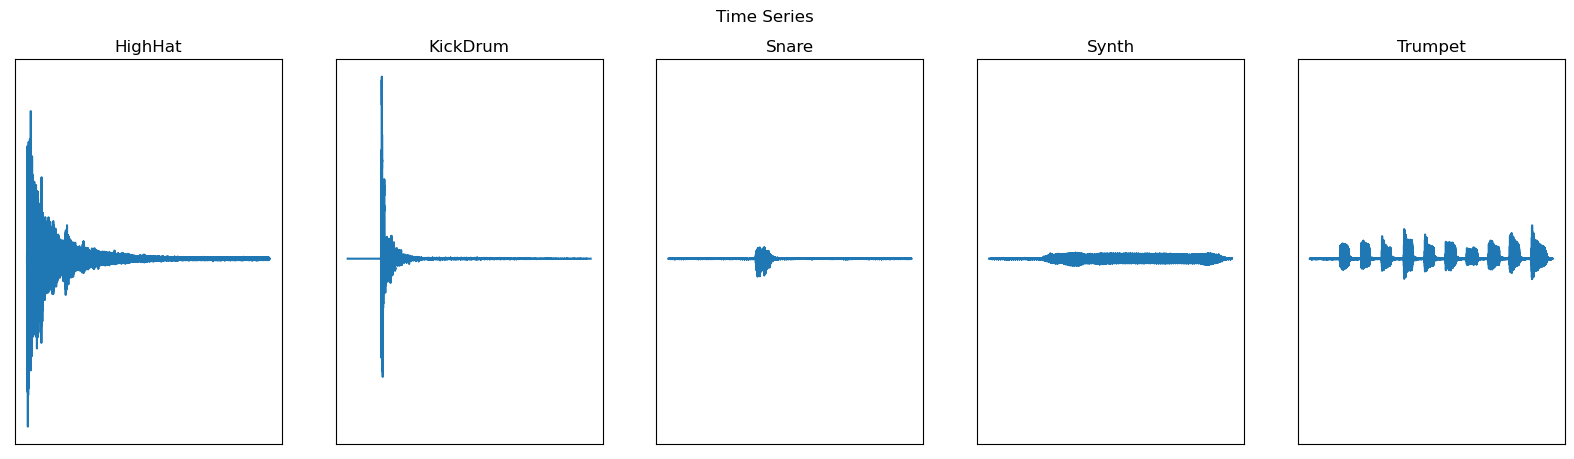

In [729]:
#Get samples

signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
    #grab a sample
    wav = df[df.Instrument == c].iloc[1,0]
    sr = wavfile.read('wavfiles/'+file)[0]      #sampling rate
    signal, rate = librosa.load('wavfiles/'+wav,sr = sr)

    signals[c] = signal
    fft[c] = calculate_fft(signal,rate)
    fbank[c] = logfbank(signal[:rate],rate,nfilt=26,nfft=int(sr/39)).T
    mfccs[c] = mfcc(signal[:rate],rate,numcep=13,nfilt=26,nfft=int(sr/39)).T

#Signals

def plot_signals(signals,title='Time Series'):
    """Plots time series signals

    Parameters:
    signals (dict): Dictionary of form, {"Class": Arr}

    Returns:
    None
    """
    fig,axes = plt.subplots(nrows=1,ncols=5,sharex=False,
                            sharey=True,figsize=(20,5))
    fig.suptitle(title)
    i = 0
    for y in range(5):
        axes[y].set_title(list(signals.keys())[i])
        axes[y].plot(list(signals.values())[i])
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i += 1
    
plot_signals(signals)

plt.show()



#### Threshold mask

We apply a threshold mask to the signal using the envelope function, referring to the envelope of a signal: visualize a boundary line enveloping every signal in the plot; this allows us to get more of the relevant amplitudes, ignoring the silent spaces, saving on computational cost in the future, the plots below are starting to look more distinct as well.


In [711]:
def envelope(signal,rate,threshold):
    """Outputs a Boolean mask based on a threshold

    Parameters: 
    signals (dict): Dictionary of form, {"Class": Arr}
    rate (int): Sampling rate e.g. 44100 if 44.1khz audio
    threshold (float): The magnitude under which audio is removed
    
    Returns:
    mask (arr)
    """
    
    #Develop a mask based on a rolling window every 10th of a second
    mask = []
    signal = pd.Series(signal).apply(np.abs)
    signal_mean = signal.rolling(window=int(rate/10),min_periods=1,center=True).mean()
    for mean in signal_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
            
    return mask

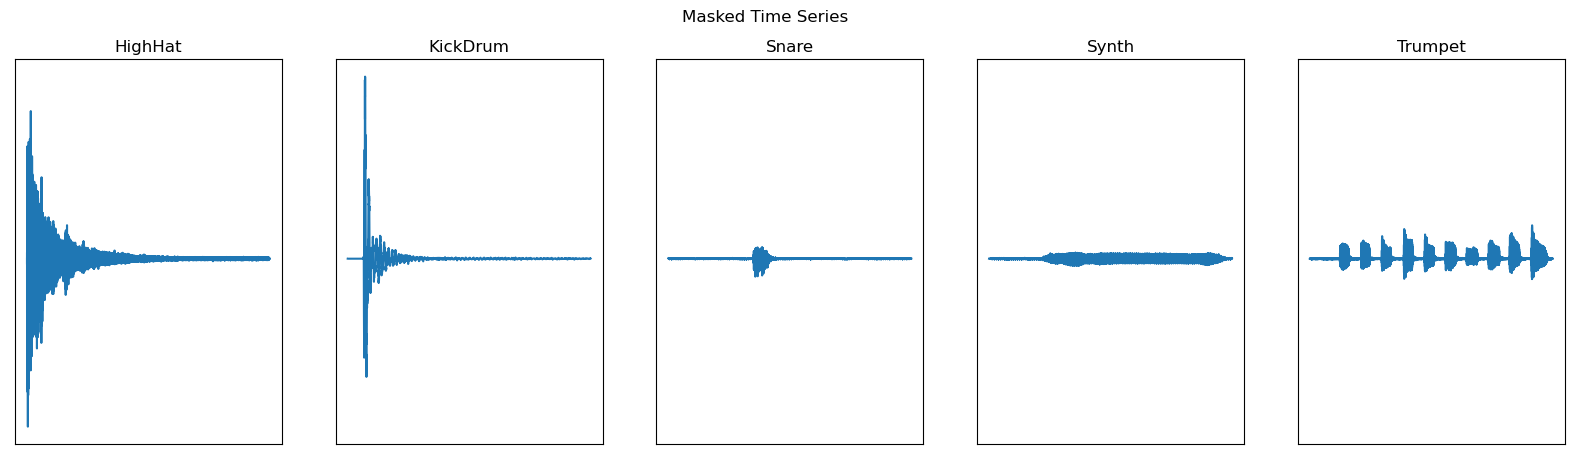

In [712]:
#Get samples

signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
    #grab a sample
    wav = df[df.Instrument == c].iloc[1,0]
    sr = wavfile.read('wavfiles/'+file)[0]      #sampling rate
    signal, rate = librosa.load('wavfiles/'+wav,sr = sr)
    mask = envelope(signal,rate,threshold=0.001)
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calculate_fft(signal,rate)
    fbank[c] = logfbank(signal[:rate],rate,nfilt=26,nfft=int(sr/39)).T
    mfccs[c] = mfcc(signal[:rate],rate,numcep=13,nfilt=26,nfft=int(sr/39)).T
    

plot_signals(signals,title='Masked Time Series')
plt.show()

#### Further Processing

Though the signal graphs above are an improvement, there are still a great deal of similarities with some e.g. if you remove the labels, would you be able to tell the difference between a snare and a synth? The aim of this pre-processing is to get to a data type which is best representative of audio, both in terms of receptibility to a model, and in terms of displaying distinctions easy for a computer to tell apart.

#### Fast Fourier Transforms

We convert these signals (which have amplitude/magnitude on the y-axis, and time on the x-axis) into periodograms using Fast Fourier Transforms, giving plots which still have magnitude on the y-axis but frequency on the x-axis. This allows us to observe different spikes in magnitude over various frequencies. Equation for a fast fourier transform: $\begin{equation}
x[k] = \sum_{n=0}^{N-1} x[n] e^\frac{{-2\pi i k n}}{N}
\end{equation}$

This equation is explained by taking N samples on a continuous signal allowing us to discretize the operation and make it more computationally efficient, and then computing the average of the peaks in the frequencies, allowing us to plot the power spectral density of a signal; in other words, letting us see which frequencies are most observable in a given signal.

The FFT graphs of the 5 instruments are plotted in the next code cell, and now we can see how different instruments have different compositions of important frequencies.

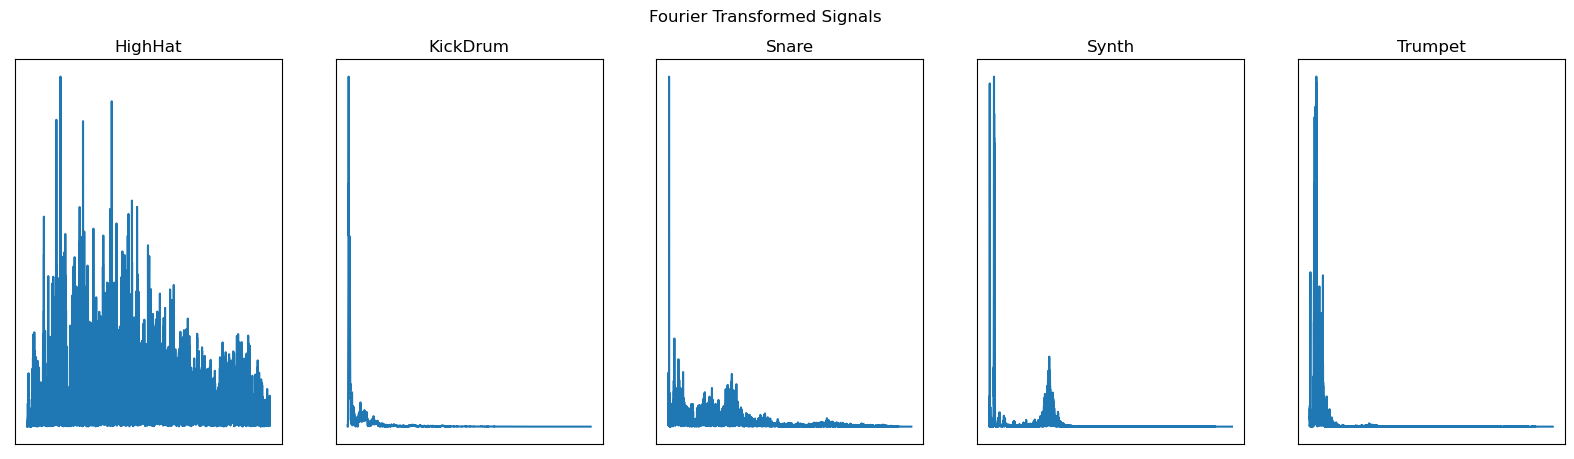

In [713]:
def calculate_fft(signal,rate):
    """Gets magnitude and frequency of a signal by doing a
    Fast Fourier Transform

    Parameters: 
    signals (dict): Dictionary of form, {"Class": Arr}
    rate (int): Sampling rate e.g. 44100 if 44.1khz audio
    
    Returns:
    magnitude,frequency (arr)
    
    """
    n = len(signal)
    frequency = np.fft.rfftfreq(n,d=1/rate)
    
    #Get the real component for the y axis
    magnitude = abs(np.fft.rfft(signal)/n)
    
    return magnitude, frequency

#Fast Fourier Transforms

def plot_fft(fft):
    fig,axes = plt.subplots(nrows=1,ncols=5,sharex=True,
                            sharey=False,figsize=(20,5))
    fig.suptitle('Fourier Transformed Signals')
    i = 0
    for y in range(5):
        data = list(fft.values())[i]
        magnitude, frequency = data[0], data[1]
        axes[y].set_title(list(fft.keys())[i])
        axes[y].plot(frequency,magnitude)
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i += 1

plot_fft(fft)
plt.show()

Note that in the FFT plots, we have the magnitude (y-axis) and frequency (x-axis) information, but have lost the time information which is relevant to distinguish accurately between the 5 classes. So now we need some way to get all three pieces of information, i.e., frequency, magnitude, and time for a signal all on the same plot in a format that a model can easily process.

#### Enter: Spectrograms

Spectograms display the frequency of a signal on the y axis, the time on the x axis, and the magnitude of the signal using a color map. The first to this is a short-time fourier transform which takes the original signal, does fourier transforms on consecutive windows, and stacks the resulting plots on top of eachother. The next step in the feature engineering is to focus more on the human auditory range wherein there is a greater emphasis and recognition for lower frequency sounds as opposed to higher frequency ones (e.g. telling the difference between 10kHz and 110kHz is much easier than 10,000kHz and 10,100kHz). The way to do this is to transform the frequencies of the signal into the Mel Scale which is a logarithmic transformation. 

Since we again lose information by converting frequencies onto the Mel Scale by choosing only a discrete number of "important frequencies", we mitigate this by using the triangular filterbank which essentially takes the weighted average of the frequencies within each triangle, represented as one value known as the Filter Bank Coefficient. The standard number of triangular filters are 26, giving us a matrix which is 26xn where n represents the time, and 26 represents the Mel-Frequencies. These are represented below as a Mel Spectrogram.

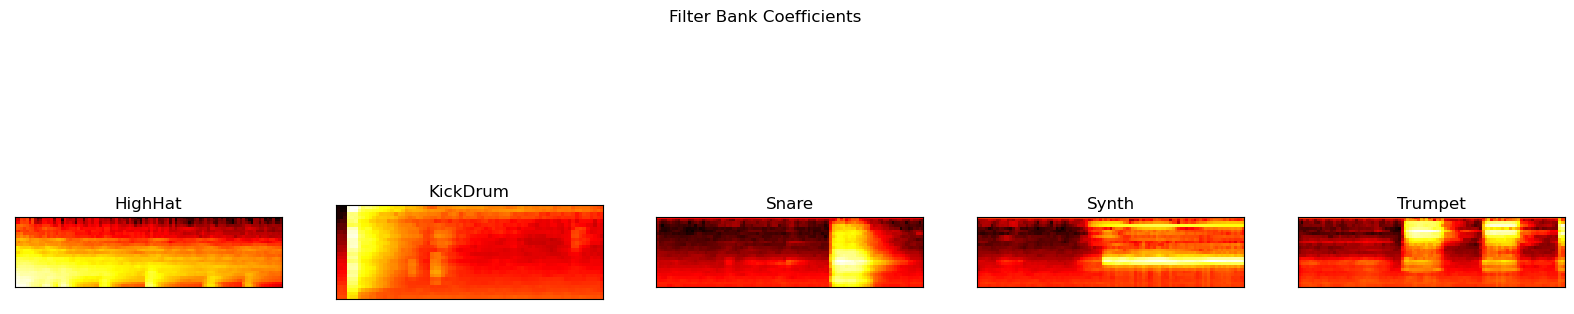

In [714]:
def plot_fbank(fbank):
    fig,axes = plt.subplots(nrows=1,ncols=5,sharex=False,
                            sharey=True,figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients')
    i = 0
    for y in range(5):
        axes[y].set_title(list(fbank.keys())[i])
        axes[y].imshow(list(fbank.values())[i],cmap='hot',interpolation='nearest')
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i += 1

plot_fbank(fbank)
plt.show()



#### Mel Frequency Cepstrum Coefficients

One final step is to compact the information down into lower frequency information by doing a discrete cosine transformation to go from a 26xN matrix to a 13xN matrix, again decreasing computational cost for future processing of the data. The resulting spectrogram is plotted below, again, emphasizing lower frequencies over higher ones. This is analogous to a low-pass filter where higher frequencies are a) not as distinctive to many sounds, and b) not useful to the human auditory system in processing the data.

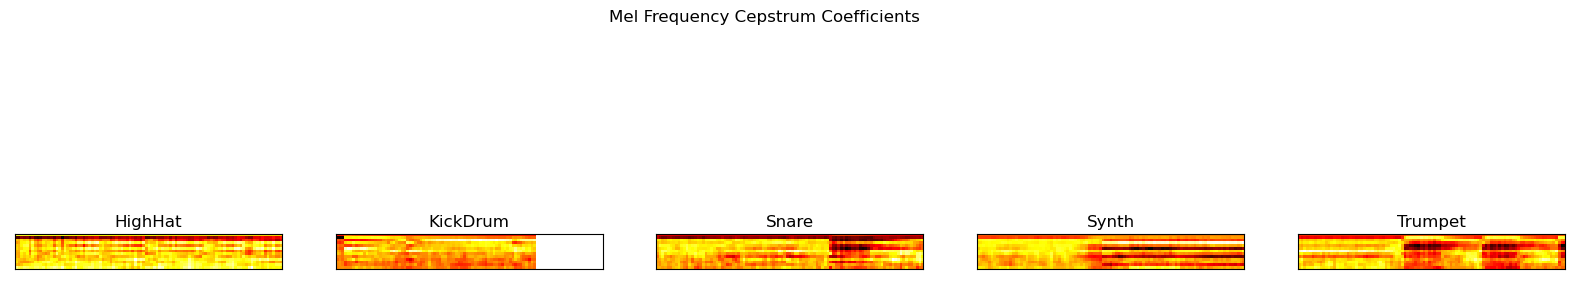

In [715]:
def plot_mfccs(fbank):
    fig,axes = plt.subplots(nrows=1,ncols=5,sharex=True,
                            sharey=True,figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients')
    i = 0
    for y in range(5):
        axes[y].set_title(list(mfccs.keys())[i])
        axes[y].imshow(list(mfccs.values())[i],cmap='hot',interpolation='nearest')
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i += 1
        
plot_mfccs(mfccs)
plt.show()

#### Downsampling

Another piece of feature engineering for the input type of .wav files is to downsample from 44.1kHz and 44kHz files to 16kHz, saving on memory usage, as well as standardizing the variety of sampling rates in all the input files.

In [716]:
#Downsampling high frequency

if len(os.listdir('Cleaned')) == 0:
    for file in tqdm(df.File):
        signal, rate = librosa.load('wavfiles/'+file,sr=16000)
        mask = envelope(signal,rate,0.0005)
        wavfile.write(filename='Cleaned/'+file,rate=rate,data=signal[mask])
        

### Part 4 - Discussing the Task

Now that have our data type i.e. a matrix represented as a 2-dimensional image, we can begin thinking about an appropriate model and the task at hand.


#### Classification

The task at hand is audio classification. Once we have converted all the data into MFCCs (Mel Frequency Cepstrum Coefficients) which represent the 2D images discussed at the end of Part 3, we want to feed this data into a Convoluted Neural Network to classify as one of the 5 instruments: Kick Drum, High Hat, Snare, Synth, or Trumpet.



##### Data Preparation

The training and test data is generated using the build_random_feature() function below which outputs around 17,000 samples from randomly selected .wav files with randomly selected 100ms samples from each .wav file, outputted into a tensor X with shape (17768, 9, 13, 1) which represent the number of samples, the time as 9, the 13 MFCCs, and a 1 for the number of channels. In other words, the height and width of the Mel Frequency Cepstrum Coefficients images from Part 3 are the 2nd and 3rd dimension of the tensor, and the 4th dimension just tells us the number of channels which is 1 since we are not looking at an RGB image, rather just a grayscale image (despite its coloured representation in Part 3) and a matrix y which is a hot-encoded matrix representing rows of 0s and 1s, where a 1 represents the column of the label: y.shape = (17768, 5) with the number of samples and the number of labels respectively. 

This data is then split 80-20 where 80% of the data is used for training the CNN, and then 20% is reserved for evaluating the model after it has been trained. The validation sets are generated dynamically within the model.fit() function itself for the CNN. The 80% is justified in order to ensure that much of the data is used for training to avoid underfitting the model while allowing some leeway to also prevent overfitting it. The validation sets are kept as 10% of the training data for every epoch run, and what it allows us to do is a) estimate the performance of the model before having to evaluate it on the test data, allowing for tuning of the hyperparameters, and b) helps us know if too many epochs are run (e.g. the validation accuracy starts approaching 100%, we know that we might be overfitting and should stop early).



In [717]:

class Configuration:
    '''
    Class to allow for easy tuning of some parameters without 
    making changes in multiple places.

    Attributes:
        nfilt (int): number of triangular filter banks, conventionally
        set to 26.
        nfeat (int): number of mel spectrum coefficients
        nfft (int): size of fast fourier transform samples
        rate (int): sampling rate, set to 16kHz
        step (int): defines time for each step used for random sampling
        audio, set at 100ms
        model_path: path to store the CNN model
        p_path: path to store the pickle for the data

    '''
    def __init__(self,nfilt = 26, nfeat = 13, nfft = 512, rate = 16000):
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        #tenth of a second step
        self.step = int(rate/10)
        self.model_path = os.path.join('models','convolution.model')
        self.p_path = os.path.join('pickles','convolution.p')

In [718]:
def check_data(configuration):
    '''
    Function checking if the input data has already been generated
    
    Input
    configuration (Configuration class)
    
    Output
    tmp: The data for the CNN if already generated
    
    '''
    if os.path.isfile(configuration.p_path):
        print('Loading data for convolution model')
        with open(configuration.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

In [719]:

sample_length = 0.1
n_samples = 2 * int(df['Length(s)'].sum()/sample_length) #for sufficient data

probability_distribution = distribution/distribution.sum()

choices = np.random.choice(distribution.index,p=probability_distribution)

configuration = Configuration()

def build_random_feature(n_samples,distribution,probability_distribution,df,configuration,classes):
    '''
    Function generating MFCC samples for the CNN
    
    Input
    n_samples (int): number of samples to generate
    distribution (arr): the class distribution
    probability_distribution (arr): normalized class distribution
    df (DataFrame): the DataFrame of .wav files with labels to sample from
    configuration (Configuration)
    classes (arr): list of class names
    
    Output
    X (4D array): Tensor of audio samples with MFCC values representing
    MFCC images
    y (2D array): Hot-encoded label matrix
    
    '''
    tmp = check_data(configuration)
    if tmp:
        print('Data pre-loaded')
        return tmp.data[0], tmp.data[1]
    
    
    X = []
    y = []
    
    #to know which values to normalize the data with for CNN input
    _min, _max = float('inf'), -float('inf')
    df.reset_index(inplace=True)
    df.set_index('File',inplace=True)
    
    for i in tqdm(range(n_samples)):
        random_class = np.random.choice(distribution.index,
                                        p=probability_distribution)
        #Get File
        file = np.random.choice(df[df.Instrument==random_class].index)

        rate, wav = wavfile.read('Cleaned/'+file)
        label = df.at[file,'Instrument']
        #Sample at a random index and get a 10th of a second after that index
        random_index = np.random.randint(0,wav.shape[0]-configuration.step) #subtract so as not to go to end of file
        sample = wav[random_index:random_index+configuration.step]
        
        #X is a matrix
        X_sample = mfcc(sample,rate,
                        numcep=configuration.nfeat,
                        nfilt=configuration.nfilt,
                       nfft=configuration.nfft)
        _min = min(_min,np.amin(X_sample))
        _max = max(_max,np.amax(X_sample))
        X.append(X_sample)
        y.append(classes.index(label))
    X, y = np.array(X), np.array(y)
    
    #normalize X
    X = (X - _min)/(_max - _min)
    
    #to add the gray scale channel to X
    X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
    
    #hot encoded y variable
    y = to_categorical(y,num_classes = 5)
    
    df.reset_index(inplace=True)

    configuration.min = _min
    configuration.max = _max
    configuration.data = (X,y)
    
    #save data once generated
    with open(configuration.p_path,'wb') as handle:
        pickle.dump(configuration,handle,protocol=2)
    
    print('Data generated')
    
    return X, y

X,y = build_random_feature(n_samples,
                           distribution,
                           probability_distribution,
                           df,
                           configuration,
                           classes)

#Split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)


100%|███████████████████████████████████████████████████████████████████████████| 17768/17768 [00:56<00:00, 317.14it/s]


Data generated


### Part 5 - CNN Model

Since our audio data has effectively been converted into an image, a CNN is useful here as it functions by moving filters or windows over parts of the images to try and learn patterns in the image, putting together than information, and making a guess about what that pattern is.

The convolution in CNNs come from the idea of using the mathematical operation of convolution (just like multiplication or addition are an operation) to go from small local features in an image, for instance a rounded contour present only in the Trumpet's MFCC image, into a defining it in a way that a computer understands: one filter generates a feature map representing a particular pattern in the image, many filters therefore generate and are able to "detect" or "identify" many different features about an MFCC image such as the curves in observed in a particular image.

#### Sequential

The Sequential model in Keras allows us to, in a sequence, stack up layers of neurons on top of eachother allowing us a great deal of freedom to play around with the order of the layers, the types of layers, their activation functions, and the number of neurons in them.


#### Going Layer by Layer

##### Conv2D

The Conv2D layer is where there are a number of filters, represented by the first argument e.g. 16 filters for the first convolution layer, a size for the filter set at 3x3 pixels; and the activation function which takes in the output from a convolution layer (the feature map) and introduces non-linearity to represent non-linearity in the shapes of the features. The strides just represent the walk: the filters move one pixel at a time. The padding being the same prevents information loss at the edges of the MFCC image. We have a 1x1 stride since the input space of the image (9x13) is quite small, remember, it is only a 10th of a second sample each time, and so we can afford going pixel by pixel.

When we stack many of these with increasing number of filters in each convolution layer, we are essentially getting towards finer and finer details in the images, as well as more complex "ideas" being captured by the layer. One way to analogize this is to consider the first layer being able to tell you that there is a straight line with a curve in the image, the second layer can tell you more specifically that the straight line might have a nook near the beginning before it starts to curve out, the third layer might be able to tell you the exact fashion in which that curve happens, so on and so forth.

The high level mathematics underpinning this is actually just a dot-product between the input MFCC image represented as 2D matrix, dotted with the kernel, where each dot product results in a scalar resulting as one element in the feature map, and repeated sliding of the filter over the input image fills out the rest of the feature map matrix as the output. The movement of the filter across the image represents the convolution operation as different regions of the input image are dotted with the kernel, one at a time.


##### MaxPool2D

The max pooling layer is used in recognition of the complexity of output from the consecutive convolution layers: their purpose is to divide the feature maps from the Conv2D layers into pools, simplifying them by taking the largest value in each pool, and discarding the rest of the information. The idea is to retain only the important information and get rid of the rest to maintain computational efficiency, as well as prevent overspecification of the image features from the MFCC images to avoid over fitting. As we can see in the model summary below the dimensions of the outputted feature map reduces by around 2.

The concept is similar to the layer above, where you can imagine a "filter" passing over the feature map outputted by the Conv2D layer, and for every 2x2 region, the max value is selected and mapped to an output array, and then the filter strides over the entire feature map similar to the convolution operation.


One might think that based on this, you would want to pool down after every convoluted layer, but since the input matrix is already quite small in its dimensions (remember that the MFCC image is 9x13), pooling down once is sufficient.

##### Dropout

After all this effort, we randomly Dropout half of the units in the feature map!

Though it seems counterintuitive, setting half of the outputted features to 0 (dropping them out), is actually a good way to prevent the model from overfitting. The theory behind this is that by preventing the model from keeping the same outputs throughout the network, by dropping some inputs out, the model is forced to be more robust to learning features as it can no longer rely on just one input. This increases the generalizability of the model; another way to think about this is that at a certain point, the CNN might start taking in random noise in the data and using that as a "feature" of the instrument's MFCC image, the dropout layer mitigates that.


##### Flatten

After all that convolution, it is time for the data to return to a 1D vector to be taken as an input by a layer of densely connected neurons. The Flatten method just takes everything in that was outputted by the previous layer and lays it out from one end to the other, going from a (None, 4, 6, 128) tensor to a 1d vector of size 3072.


##### Dense

This is where we return to classic neural networks (somewhat). The Dense layers represent fully connected layers i.e. every single neuron in the layer is connected to every neuron in the one behind and in front of it. Using all of the features learnt by the convolved network, the dense layers start slowly going down to output to the 5 classes which we need. The final dense layer has a softmax activation function as we want the output to be between 0 and 1, as is often the case in multiclass classification problems like this one.

The softmax function works as $softmax(x_i) = \frac{e^{x_i}}{\sum e^{x_j}}$ where the output of the ith neuron in the last layer is exponentiated and divided by the sum of all such neurons in the final layer, allowing us to normalize the outputs to 1. This is useful as it is a proxy for determining how certain, for a given input, the model is about classification. E.g., 0.9 output for a trumpet input on the trumpet neuron is a good first step to start labeling the softmax output back into the categorical variables.



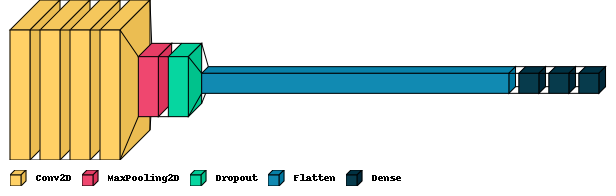

In [720]:
#Visual representation of the layers in the CNN

visualkeras.layered_view(model, legend=True,scale_xy=10)


In [721]:
#Convolution model

def get_model(input_shape):
    model = Sequential()
    model.add(Conv2D(16,(3,3),activation='relu',strides=(1,1),padding='same',input_shape=input_shape))
    model.add(Conv2D(32,(3,3),activation='relu',strides=(1,1),padding='same'))
    model.add(Conv2D(64,(3,3),activation='relu',strides=(1,1),padding='same'))
    model.add(Conv2D(128,(3,3),activation='relu',strides=(1,1),padding='same'))
    
    model.add(MaxPool2D((2,2)))
    
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(5,activation='softmax'))
    
    model.summary()
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    
    return model

input_shape = (X_train.shape[1],X_train.shape[2],1)
model = get_model(input_shape)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 9, 13, 16)         160       
                                                                 
 conv2d_35 (Conv2D)          (None, 9, 13, 32)         4640      
                                                                 
 conv2d_36 (Conv2D)          (None, 9, 13, 64)         18496     
                                                                 
 conv2d_37 (Conv2D)          (None, 9, 13, 128)        73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 4, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 4, 6, 128)         0         
                                                      

### Part 6 - Training


The model.compile method allows us to determine the way the model learns through the training. The loss function is categorical cross entropy which calculates and aims to minimize the difference between the true and predicted probability distributions. For instance, if the prediction for a trumpet is [0.9, 0.1, 0, 0, 0] as an output from the CNN indicating that it thinks that there is a 90% probability of the sound being a trumpet and 10% being a kick drum and 0% for others, this is compared against the true vector which is just [1,0,0,0,0]. The formula for categorical cross entropy is as follows:

$CE = -\sum_{i=1}^{i=N} ytrue_{i} \cdot log(ypred_{i})$

This is interpreted as the negative sum of the dot products between the true vector and the log of the predicted vector. The smaller the value, the closer the predicted probability distribution is to the true answer.

The optimizer is set as Adam which computes the gradient of the loss function w.r.t. the weights and biases, updating them based on the direction of the correct gradient. This is a popular optimizer as it includes a "momentum" term that prevents getting stuck in local minimas when minimizing the loss function, helping convergence to the global minimum. The momentum has to do with how much of the previous update is used to determine the next update of the gradient (visualize the momentum with which a ball rolls across a hill aiming to find the global minimum).

The chosen metric to evaluate the model is accuracy representing the proportion of correctly classified instruments from the samples. This will later be paired with other metrics, namely, precision, recall, and F1 score in a later section. However, given the relative class balance, accuracy will not suffer from the pitfalls of class imbalance.

The model is run for 10 epochs meaning 10 passes of the training data to update the model parameters, a balance between large and small batch size is used at 32 to increase speed while maintaining smooth gradient updates. The shuffle parameter is used to ensure that the training data is shuffled each time, preventing "memorization" of the training data in a particular order i.e. a scenario where the model is overfit to a certain order of data. The validation split parameter splits 10% of the training data each pass to evaluate the accuracy metric every epoch; note that the validation metric is not used to update the parameters. Finally, callbacks references the checkpoint which allows us to store the best model weights so far based on the metric of accuracy.

In [722]:
checkpoint = ModelCheckpoint(configuration.model_path, monitor='acc',verbose=1,
                             mode='max',save_best_only=True,save_weights_only=False,save_freq='epoch')

In [723]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


history = model.fit(X_train,y_train,
          epochs=10,
          batch_size=32,
          shuffle=True,
          validation_split=0.1,
          callbacks=[checkpoint])



Epoch 1/10
399/400 [============================>.] - ETA: 0s - loss: 0.8524 - acc: 0.6632
Epoch 1: acc improved from -inf to 0.66354, saving model to models\convolution.model
400/400 [==============================] - 19s 46ms/step - loss: 0.8518 - acc: 0.6635 - val_loss: 0.5510 - val_acc: 0.7918
Epoch 2/10
399/400 [============================>.] - ETA: 0s - loss: 0.4905 - acc: 0.8162
Epoch 2: acc improved from 0.66354 to 0.81621, saving model to models\convolution.model
400/400 [==============================] - 19s 48ms/step - loss: 0.4905 - acc: 0.8162 - val_loss: 0.3818 - val_acc: 0.8502
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.3637 - acc: 0.8660
Epoch 3: acc improved from 0.81621 to 0.86601, saving model to models\convolution.model
400/400 [==============================] - 18s 46ms/step - loss: 0.3637 - acc: 0.8660 - val_loss: 0.2860 - val_acc: 0.9023
Epoch 4/10
400/400 [==============================] - ETA: 0s - loss: 0.3068 - acc: 0.8856
Epoch 

### Part 7 - Model Evaluation and Predictions

The two plots below show the changes in accuracy for the training sets and the validation sets in the 10 epochs run. They currently look non-informative as they are running based on an already run model and therefore do not have much improvement. Once run from scratch, there ought to be a steady increase in the accuracy of the model, and a similar steady decrease in its loss function.

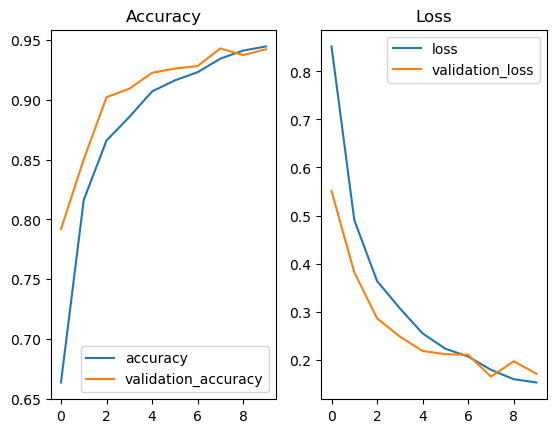

In [724]:
def acc_val_acc_plot():
    fig, axs = plt.subplots(1, 2)
    
    
    axs[0].plot(history.history['acc'], label='accuracy')
    axs[0].plot(history.history['val_acc'], label='validation_accuracy')
    axs[0].set_title('Accuracy')
    axs[0].legend(loc='best')

    axs[1].plot(history.history['loss'], label='loss')
    axs[1].plot(history.history['val_loss'], label='validation_loss')
    axs[1].set_title('Loss')
    axs[1].legend(loc='best')

acc_val_acc_plot()
plt.show()

#### Predictions and bringing in the test data

The following code cell summarizes metrics of precision, recall, and F1 score as previously discussed, on the testing data set. All three of these metrics score around 0.9 or above.

##### Metric interpretations

The high precision is interpreted as the number of positive classifications which are actually positive, meaning that the false positive rate for the model is low. This means that if the model says that an instrument is a high hat, its probably correct.

The high recall is the proportion of correctly identified positive instances implying a low false negative rate, meaning that if the model tells us that an instrument is not a kick drum, again, it is probably right. 

F-1 score is just a balanced measure representing both precision and recall, as we can see from the formula in the code cell below where it is the harmonic mean of both measures. The high f1 scores for all the instrument implies that there is a good balance between precision and recall in the model.

In [725]:
#Sklearn Classification report

testloss, testacc = model.evaluate(X_test, y_test,verbose=0)

y_pred = model.predict(X_test)


#converts from probabilities to the most probable class since our y-data
#was hot-encoded
y_pred_classes = np.argmax(y_pred,axis=1)

y_true_classes = np.argmax(y_test,axis=1)


print(classification_report(y_true_classes, y_pred_classes))


112/112 [==============================] - 3s 27ms/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       575
           1       0.91      0.90      0.90       492
           2       0.86      0.96      0.91       674
           3       0.98      0.91      0.94       686
           4       0.99      0.95      0.97      1127

    accuracy                           0.94      3554
   macro avg       0.94      0.94      0.94      3554
weighted avg       0.95      0.94      0.94      3554



#### Confusion matrix based on predictions

The predictions made by the model on the test data is plotted below as a confusion matrix, which demonstrates along the off diagonal a high performance by the model in determining whether an instrument has been correctly classified or not, as the closer the color is to yellow, the higher the proportion of correct classifications. For instance, if you look at the first row of the confusion matrix, the highhat - highhat intersection implied that most highhats were classified correctly, and the purples in the other intersections e.g. highhat - kick drum (values close to 0) imply that not many high hats were misclassified as kick drums.

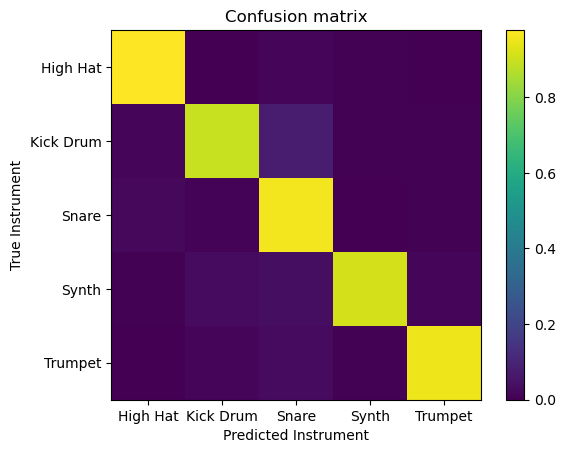

Precision: [0.95769497 0.94319502 0.86017821 0.97687521 0.97481282]
Recall: [0.9773913  0.89634146 0.96142433 0.91399417 0.95119787]
F1 Score: [0.9674429  0.91917156 0.9079876  0.94438913 0.96286057]


In [726]:
labels =['High Hat','Kick Drum','Snare','Synth','Trumpet']
cm = confusion_matrix(y_true_classes, y_pred_classes,normalize='true')
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
plt.xticks(np.arange(5),labels)
plt.yticks(np.arange(5),labels)
plt.xlabel('Predicted Instrument')
plt.ylabel('True Instrument')
plt.show()


precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_score = 2 * precision * recall / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

##### What the predictions actually look like in a data frame
The following code cell converts the csv containing the dataset and appends the probability distributions of the predictions, as well as the most likely instrument for each .wav file. All of the predictions are obviously correct as this is the data which was both trained and tested on but are a useful visual aid to see what is being generated behind the scenes.

In [727]:
file2class = dict(zip(df.File,df.Instrument))

def predictions(audio_directory,model):
    y_true = []
    y_pred = []
    prob = {}
    
    print('Getting features from audio files')
    for file in tqdm(os.listdir(audio_directory)):
        rate, wav = wavfile.read(os.path.join(audio_directory,file))
        label = file2class[file]
        c = classes.index(label)
        y_prob = []
        
        for i in range(0,wav.shape[0]-configuration.step,configuration.step):
            sample = wav[i:i+configuration.step]
            x = mfcc(sample,rate,
                        numcep=configuration.nfeat,
                        nfilt=configuration.nfilt,
                       nfft=configuration.nfft)
            x = (x - configuration.min)/(configuration.max - configuration.min)
            x = x.reshape(1,x.shape[0],x.shape[1],1)
            y_hat = model.predict(x,verbose=0)
            y_prob.append(y_hat)
            y_pred.append(np.argmax(y_hat))
            y_true.append(c)
        
        prob[file] = np.mean(y_prob, axis=0).flatten()
        
    return y_true, y_pred, prob
p_path = os.path.join('pickles','convolution.p')

with open(p_path,'rb') as handle:
    configuration=pickle.load(handle)
    
model = load_model(configuration.model_path)


y_true, y_pred, fn_prob = predictions('Cleaned',model)

accuracy = accuracy_score(y_true=y_true,y_pred=y_pred)
y_probs = []

for i,row in df.iterrows():
    y_prob = fn_prob[row.File]
    y_probs.append(y_prob)
    for c,p in zip(classes,y_prob):
        df.at[i,c] = p

y_pred = [classes[np.argmax(y)] for y in y_probs]

df['y_pred'] = y_pred

df.to_csv('predictions_all.csv',index=False)

pred = pd.read_csv('predictions_all.csv')

pred.head()

Getting features from audio files


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [09:54<00:00,  2.54s/it]


,File,index,Instrument,Length(s),HighHat,KickDrum,Snare,Synth,Trumpet,y_pred
0,06c48eab.wav,0,HighHat,4.18,0.999053,1.969244e-04,0.000004,7.400675e-04,6.017282e-06,HighHat
1,078f7ac0.wav,1,HighHat,3.14,0.999935,6.756699e-08,0.000063,1.577644e-06,2.711486e-07,HighHat
2,09a1cfd7.wav,2,HighHat,1.68,0.999983,2.977226e-07,0.000016,5.741511e-08,1.510493e-09,HighHat
3,0ed06544.wav,3,HighHat,3.14,0.999893,2.269930e-07,0.000107,1.274754e-07,3.817471e-08,HighHat
4,2032be87.wav,4,HighHat,3.14,0.999989,7.681963e-10,0.000011,1.007163e-08,6.524679e-08,HighHat


### Live Prediction!

Rather than take my word for it, run the following code cell and start making some noise. There will inevitably be some misclassifications but the model displays surprising accuracy, especially given that it works on only 100ms of samples everytime.

In [ ]:
#Initialize the textbox and the label names

textbox = widgets.Text(description="Progress:", value="Starting...")
display(textbox)
labels = ['High Hat', 'Kick Drum', 'Snare', 'Synth', 'Trumpet']



def is_loud_enough(window, threshold):
    '''
    Returns a boolean to ensure that the input is loud enough so that it doesn't try to classify
    ambient noise
    '''
    return np.mean(np.abs(window)) > threshold



#Starts the recording!

while True:
    
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 16000
    CHUNK = 1024
    RECORD_SECONDS = 0.15
    WAVE_OUTPUT_FILENAME = "output.wav"

    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    
    
    frames = []
    
    #This piece of code waits for the the input to be loud enough before recording
    while True:
        # Read a chunk of audio
        data = stream.read(CHUNK)
        window = np.frombuffer(data, dtype=np.int16)
        if is_loud_enough(window, threshold=150):
            frames.append(data)
            break

    #Here is when the recording actually starts
    

    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    stream.stop_stream()
    stream.close()
    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()

    
    #Repeat the same steps as before to get the data from the recorded .wav file
    rate, wav = wavfile.read('output.wav')
    
    #This time we want the start of the sample rather than a random portion of it
    sample = wav[0:0+configuration.step]

    #Get the data into the type which our model processes
    X = mfcc(sample,rate,
                    numcep=configuration.nfeat,
                    nfilt=configuration.nfilt,
                   nfft=configuration.nfft)
    
    
    #Normalization as before
    _min,_max = np.amin(X),np.amax(X)
    X = (X - _min)/(_max - _min)

    
    #Reshaping into the input shape taken in by model.predict
    X = X.reshape(1,X.shape[0],X.shape[1],1)

    
    predicted_class = model.predict(X,verbose=0)[0]

    
    print(labels[np.argmax(predicted_class)])
    textbox.value = f"Instrument: {labels[np.argmax(predicted_class)]}"


#### Discussion and Conclusion

The after playing around with the live classifier, it seems that it has some trouble categorizing the kick drum in particular. This is either because my kick drum might not be bassy enough for it, or that the training data was too bassy to begin with. There are a number of improvements to be made with this model, first and foremost being that the training data should consist entirely of mouth-generated noises if the aim is for the classifier to classify mouth-generated noises. 

A technical improvement to make would be to use batch normalization with the training data which essentially normalizes all the inputs given to each layer in the CNN. This would lead to faster training of the model and an increase in the generalization of predictions it can make as well.



### Part 9 - Executive Summary

This project focused on beginner beatboxing, using a dataset of 234 .wav audio files for 5 classes (kick drum, high hat, synth, trumpet, and snare) from various sources. The aim was to create an audio classifier capable of taking in user input and outputting what it thinks is the closest instrument it is.

Using a pandas dataframe, the class distribution for a dataset of audio files was plotted in a pie-chart. Although there was some imbalance, it was not a major concern, as a perfectly balanced dataset is not realistic for real-world applications.

Exploratory data analysis revealed that the inputted signals required a threshold mask to get rid of the silent portions of a sample to focus on relevant features of the signal. The main conversion of the data was then from the masked audio signal → fourier transformed signal → mel filterbanks → mel frequency cepstrum coefficients where the final one was the data type used as the input for the final model.

Around 17,000 samples of 1/10th of a second audio was generated from the dataset, which was then split 80-20 for the training and test sets. The format of X was a 4D tensor, and y as a hot-encoded matrix of labels. The validation sets were created using the inbuilt functionality of model.fit(), set at 10% of the batch.

The CNN was the model of choice, allowing us to process .wav files as images to identify key patterns, with the architecture of the CNN visualized and explained with reference to narrowing in on key details, pooling for simplification, dropouts to prevent overfitting, and then flattening to feed into the dense network which finally outputted a 5 element vector representing the probability distribution of the classes.

The model was then trained using the CE loss function and Adam optimizer, with accuracy being used to evaluate the model during training, and checkpoints to store past models. Metrics of precision, recall, and the F1 score were then used to evaluate the model after training on the test data, paired with a confusion matrix and its interpretation model which is quite good at classification.

Finally, predictions were made, both on the entire data set, and through the live audio classifier which lets the user check themselves whether the predictions are accurate or not, alongside discussion of why the predictions might not too accurate given the kind of data the model's training started off with.



### Part 10 - References

Primary resource: https://www.youtube.com/playlist?list=PLhA3b2k8R3t2Ng1WW_7MiXeh1pfQJQi_P

This playlist was the driving inspiration behind this assignment, and much of the code utilized is rewritten from here. Rather than copy the code from a GitHub repo, I rewrote the code as I watched the videos, keeping many things similar such as the plotting code for the diagrams, while making small adjustments to fit the use-case for my particular assignment and dataset. The CNN model parameters and layering used is also based off of this playlist after testing on my own.

https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520

This resource was used to understand spectrograms.

https://www.youtube.com/watch?v=spUNpyF58BY

This resource was used to understand fourier transforms.

https://www.youtube.com/watch?v=SJo7vPgRlBQ&t=278s&ab_channel=WhyML

This resource was used to understand Melbank filters and MFCCs

Collaboration with Philip Barven:

After Philip had already submitted, we realized it is useful to highlight how working together helped us and also a nice application of #MLDevelopment 

Philip and I had several calls to discuss the assignment as it turned out both of us were using CNNs though for different tasks. Specifically:  I learnt the way to visualize the architecture of the layers, plot accuracy and loss during train, and how to generate and interpret confusion matrices when summarizing the relevant metrics for the model evaluation.
